In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# configuration
addNoise = False
addBackground = False

In [3]:
def calculateRaxis(tmax, tref, nPoints = 256, rrefmin = 0.5, rrefmax = 7.2):
    # this function computes the r-axis from the tmax of the corresponding time signal and 
    # the tmax of the "reference" time trace/r-axis pair, in all signals of the 
    # Edwards_Stoll_JMR_2018_testset r runs from [0.5 7.2]
    # nPoints is the length of the r vector that you want to receive

    # stretch factor
    stretch = (tmax/tref)**(1/3)
    
    # compute vector
    rmax = rrefmax*stretch
    rmin = rrefmin*stretch 
    r = np.linspace(rmin,rmax,nPoints)

    return r

In [4]:
# load files for learning and evaluation
PRraw = np.load('./Edwards_Stoll_JMR_2018_testset/PR.npy')
TD = np.load('./Edwards_Stoll_JMR_2018_testset/TD.npy')
Rs = np.load('./Edwards_Stoll_JMR_2018_testset/Rs.npy')
Tref = np.load('./Edwards_Stoll_JMR_2018_testset/Tref.npy')
Tmax = np.load('./Edwards_Stoll_JMR_2018_testset/TmaxVec.npy') 

# determine shape of the tensors that are used for learning
[nTraces, nTimePoints] = TD.shape
[df, nRPoints] = PRraw.shape

In [5]:
# normalization of P(r)'s
PR = np.zeros(PRraw.shape)
for Sample in range(nTraces):
    PofR = PRraw[Sample,:]
    PofR = PofR/PofR.max()
    PR[Sample,:] = PofR

# add white noise
if addNoise:
    noise = np.random.normal(0,0.2,[nTraces, nTimePoints])
    TD = TD + noise

# add Background
if addBackground:
    TD = TD

In [6]:
# divide S(t)'s into learn and evaluation sets
frac = 0.8 # fraction of S(t)'s that are used for learning
ind = int(np.floor(nTraces*frac))

learnTD = TD[:ind,:]
learnPR = PR[:ind,:]

evaluateTD = TD[ind+1:,:]
evaluatePR = PR[ind+1:,:]


In [7]:
# setup neural network
model = tf.keras.Sequential()
model.add(layers.Dense(128, activation = tf.nn.tanh, input_dim = nTimePoints))  # hyperbolic tangent activation
model.add(layers.Dense(128, activation = tf.nn.tanh))                           # hyperbolic tangent activation
model.add(layers.Dense(128, activation = tf.nn.tanh))                           # hyperbolic tangent activation
model.add(layers.Dense(256, activation = tf.nn.sigmoid))                        # logistic sigmoid activation

model.compile(optimizer = tf.compat.v1.train.AdamOptimizer(0.01),
              loss = 'mse',       # mean squared error
              metrics = ['mae'])  # mean absolute error

# learn, loop over the entire data set epochs times
model.fit(learnTD, learnPR, epochs = 10)

# evaluation, prints the mse and mae for the evaluation set
model.evaluate(evaluateTD, evaluatePR, batch_size = nTraces-ind-1)

# uncomment to show summary of the model
# model.summary()

Train on 9338 samples
Epoch 1/10
9338/9338 [==============================] - 1s 96us/sample - loss: 0.0102 - mae: 0.0417
Epoch 2/10
9338/9338 [==============================] - 1s 81us/sample - loss: 0.0044 - mae: 0.0271
Epoch 3/10
9338/9338 [==============================] - 1s 78us/sample - loss: 0.0038 - mae: 0.0251
Epoch 4/10
9338/9338 [==============================] - 1s 69us/sample - loss: 0.0035 - mae: 0.0240
Epoch 5/10
9338/9338 [==============================] - 1s 85us/sample - loss: 0.0033 - mae: 0.0232
Epoch 6/10
9338/9338 [==============================] - 1s 71us/sample - loss: 0.0030 - mae: 0.0223
Epoch 7/10
9338/9338 [==============================] - 1s 73us/sample - loss: 0.0032 - mae: 0.0225
Epoch 8/10
9338/9338 [==============================] - 1s 77us/sample - loss: 0.0046 - mae: 0.0279
Epoch 9/10
9338/9338 [==============================] - 1s 83us/sample - loss: 0.0035 - mae: 0.0242
Epoch 10/10
2334/2334 [==============================] - 0s 30us/sample - loss

[0.0033867612946778536, 0.023578735]

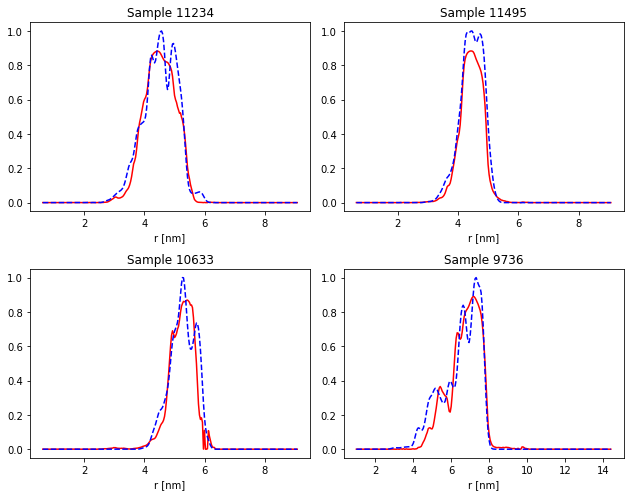

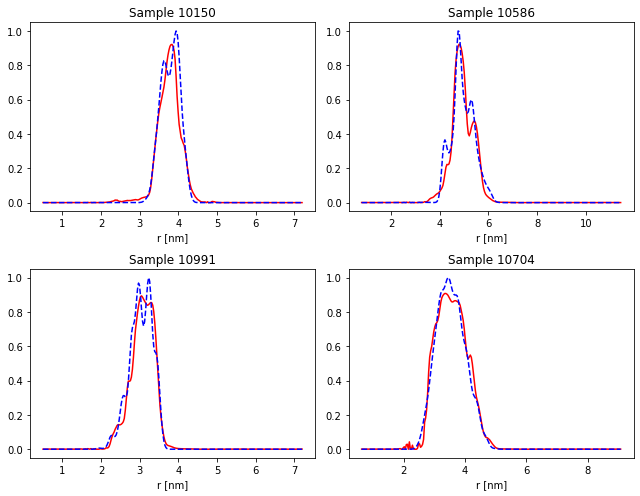

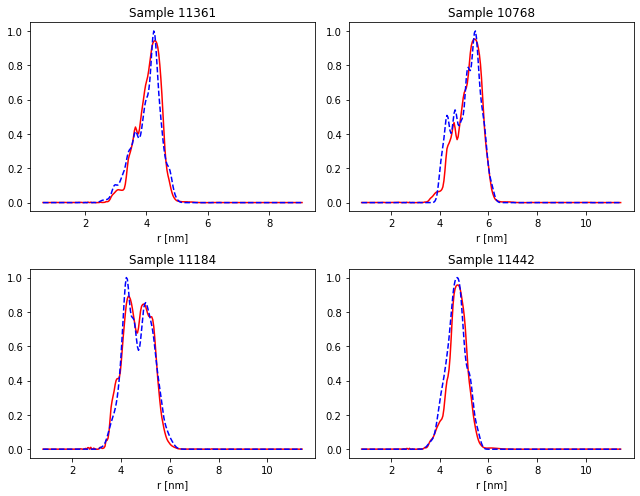

In [8]:
# plotting 
xlabel = 'r [nm]'
subtitle = 'Sample %d'

for i in range(3):

    # randomly select four traces from the evaluation set
    samples = np.random.randint(ind,nTraces,(4))
    example_batch = TD[samples,:]

    # predict P(r) using the neural network
    example_result = model.predict(example_batch)

    # compute the r vectors
    computedRs = np.zeros(example_result.shape)
    sample = 0
    for j in samples:
        r = calculateRaxis(Tmax[j],Tref)
        computedRs[sample,:] = r
        sample += 1

    # create figure with four subplots
    fig, axes = plt.subplots(2, 2,figsize=(9,7))

    axes[0, 0].plot(computedRs[0,:],example_result[0,:],'r-',Rs[samples[0],:],PR[samples[0],:],'b--')
    axes[0, 0].set_title(subtitle % samples[0])
    axes[0, 0].set_xlabel(xlabel)

    axes[0, 1].plot(computedRs[1,:],example_result[1,:],'r-',Rs[samples[1],:],PR[samples[1],:],'b--')
    axes[0, 1].set_title(subtitle % samples[1])
    axes[0, 1].set_xlabel(xlabel)

    axes[1, 0].plot(computedRs[2,:],example_result[2,:],'r-',Rs[samples[2],:],PR[samples[2],:],'b--')
    axes[1, 0].set_title(subtitle % samples[2])
    axes[1, 0].set_xlabel(xlabel)

    axes[1, 1].plot(computedRs[3,:],example_result[3,:],'r-',Rs[samples[3],:],PR[samples[3],:],'b--')
    axes[1, 1].set_title(subtitle% samples[3])
    axes[1, 1].set_xlabel(xlabel)

    fig.tight_layout()
    plt.show()

In [9]:
# print evaluation parameters again
model.evaluate(evaluateTD, evaluatePR, batch_size=nTraces-ind-1)

2334/2334 [==============================] - 0s 5us/sample - loss: 0.0034 - mae: 0.0236


[0.0033867612946778536, 0.023578735]